# Heat Equation 
## November 17th, 2022
### Overview: Using finite difference methods to solve the heat quation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import matplotlib.animation as animation
from scipy.sparse import diags
from scipy import sparse
from scipy.sparse.linalg import spsolve
from IPython.display import HTML

In [2]:
%matplotlib inline

In [3]:
def general_function(x,t,v,f):
    """
    this function does the general work for finding the solutions
    takes in linspaces x and y, a constant v (nu) and a callable function f
    """
    # lambda coefficient
    λ = v*(t[1]-t[0])/((x[1]-x[0])**2)
    
    #_t is number of points to make correct number of subintervals, _x is same for x subintervals
    _t = len(t)
    _x = len(x)
    
    #creating A matrix
    below = λ*np.concatenate([np.ones(_x-2),np.array([0])])
    main  = np.concatenate([np.array([1]),(1-2*λ)*np.ones(_x-1),np.array([1])])
    above = np.concatenate([np.array([0]),λ*np.ones(_x-2)])
    k = [below,main,above]
    offset = [-1,0,1]
    A = diags(k,offset).toarray()
    
    #get first time step using initial condition function
    U = f(x)
    
    #for every following time step, find the next time step's solution and stack onto U
    for i in range(_t-1):
        if i > 0:
            U = np.vstack([U,A@U[-1]])
        else: U = np.vstack([U,A@U])
    
    return U

In [4]:
def animate(x,u,title):
    """Saves an animation of the solution u on the spatial linspace x over the time linspace t; titles it with title"""
    #initialize the figure and axis
    plt.ioff()
    fig = plt.figure()
    ax  = fig.add_subplot(111)
    
    #set window limits
    ax.set_xlim(min(x),max(x))
    ax.set_ylim((min(min(r) for r in u), max(max(r) for r in u)))
    
    #labels and titles
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title(title)
    
    #create the trajectory plot object
    traj, = plt.plot([],[])
    
    def update(t):
        #update function updates where we are in the solution
        traj.set_data(x,u[t])
        return traj
    
    #create and save the animation
    plt.ioff()
    ani = animation.FuncAnimation(fig,update,frames=range(u.shape[0]),interval=25,repeat=True)
    ani.save(f'{title}.mp4')

# Problem 1

Consider the initial/boundary value problem

\begin{align}
	\begin{split}
	&{ } u_t = 0.05 u_{xx}, \quad x \in [0,1], \quad t \in [0,1]\\
	&{ } u(0,t) = 0,\quad u(1,t) = 0,\\
	&{ } u(x,0) = 2\max\{0.2 - |x-0.5|,0\}.
	\end{split}
\end{align}

Approximate the solution $u(x,t)$ by taking 6 subintervals in the $x$ dimension and 10 subintervals in time.
Plot the approximation at $t=0, t=0.4$, and $t=1$.

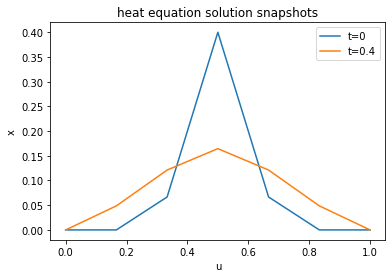

In [5]:
#defining linspaces, function
x = np.linspace(0,1,7)
t = np.linspace(0,1,11)
f = lambda x: 2*np.where(0.2-np.abs(x-0.5)>0,0.2-np.abs(x-0.5),0)

#find solution for every time
u = general_function(x,t,0.05,f)

#plotting
plt.plot(x,u[0],label='t=0')
plt.plot(x,u[4],label='t=0.4')
plt.ylabel('x')
plt.xlabel('u')
plt.title('heat equation solution snapshots')
plt.legend()
plt.show()

# Problem 2

Solve the initial/boundary value problem

\begin{align}
	\begin{split}
	&{ } u_t = u_{xx}, \quad x \in [-12,12],\quad t \in [0,1], \\
	&{ } u(-12,t) = 0,\quad u(12,t) = 0,\\
	&{ } u(x,0) = \max\{1 - x^2,0\}
	\end{split}
\end{align}

using the first order explicit method (1.1).
Use 140 subintervals in the $x$ dimension and 70 subintervals in time.
The initial and final states are shown in Figures 1 and 2.
Animate your results.

Explicit methods usually have a stability condition, called a CFL condition (for Courant-Friedrichs-Lewy).
For method (1.1) the CFL condition that must be satisfied is that:

$$\lambda \leq \frac{1}{2}$$

Repeat your computations using 140 subintervals in the $x$ dimension and 66 subintervals in time. Animate the results.
For these values the CFL condition is broken; you should easily see the result of this instability in the approximation $U^{66}$.


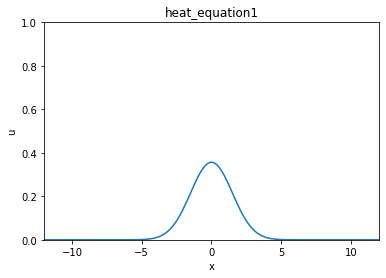

In [6]:
#plotting with stable cfl

#linspaces, function
x = np.linspace(-12,12,141)
t = np.linspace(0,1,71)
f = lambda x: np.where(1-(x**2)>0,1-(x**2),0)

#solution
u = general_function(x,t,1,f)

#animating
plt.ioff()
animate(x,u,'heat_equation1')
plt.ioff()
HTML('<video src="heat_equation1.mp4" controls>')

`<video src="heat_equation1.mp4" controls>`

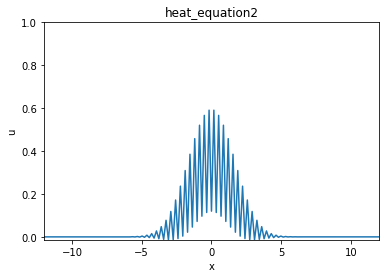

In [7]:
#plotting with unstable cfl

#linspaces and function
x = np.linspace(-12,12,141)
t = np.linspace(0,1,67)
f = lambda x: np.where(1-(x**2)>0,1-(x**2),0)

#solution
u = general_function(x,t,1,f)

#animating
plt.ioff()
animate(x,u,'heat_equation2')
plt.ioff()
HTML('<video src="heat_equation2.mp4" controls>')

`<video src="heat_equation2.mp4" controls>`

# Problem 3

Using the Crank Nicolson method, numerically approximate the solution $u(x,t)$ of the problem
\begin{align}
	\begin{split}
	&{ } u_t = u_{xx}, \quad x \in [-12,12],\quad t \in [0,1],\\
	&{ } u(-12,t) = 0,\quad u(12,t) = 0,\\
	&{ } u(x,0) = \max\{1 - x^2,0\}.
	\end{split}
\end{align}
Note that this is an implicit linear scheme; hence, the most efficient way to find $U^{j+1}$ is to create the matrix $B$ as a sparse matrix and then use \li{scipy.sparse.linalg.solve}.

Demonstrate that the numerical approximation at $t = 1$ converges.
Do this by computing $U$ at $t=1$ using $20,40,80,160,320$, and $640$ steps.
Use the same number of steps in both time and space.
Reproduce the loglog plot shown in the lab.
The slope of the line there shows the order of convergence.

To measure the error, use the solution with the smallest $h$ (largest number of intervals) as if it were the exact solution, then sample each solution only at the x-values that are represented in the solution with the largest $h$ (smallest number of intervals).
Use the $\infty$-norm on the arrays of values at those points to measure the error.

Notice that, since the Crank-Nicolson method is unconditionally stable, there is no CFL condition, and we can safely use the same number of intervals in time and space.

In [11]:
def heat_cn(nu,f,xbounds,tbounds,xsteps,tsteps):
    """Computes the Crank-Nicholson solution to the heat equation initial/boundary
    value problem:
    
        u_t = νu_xx, x∈[x0,x1] t∈[t0,t1]
        u(x0,t) = 0, u(x1,t) = 0
        u(x,0) = f(x)
    """
    #linspaces within bounds
    x = np.linspace(xbounds[0],xbounds[1],xsteps+1)
    t = np.linspace(tbounds[0],tbounds[1],tsteps+1)
    #_t is number of points to make correct number of subintervals, _x is same for x subintervals
    _t = len(t)
    _x = len(x)
    
    #lammy
    λ = nu*(t[1]-t[0])/(2*(x[1]-x[0])**2)
    
    #creating A matrix
    below = λ*np.concatenate([np.ones(_x-2),np.array([0])])
    main  = np.concatenate([np.array([1]),(1-2*λ)*np.ones(_x-1),np.array([1])])
    above = np.concatenate([np.array([0]),λ*np.ones(_x-2)])
    k = [below,main,above]
    offset = [-1,0,1]
    A = sparse.csr_matrix(diags(k,offset))
    
    #creating B matrix
    below = -λ*np.concatenate([np.ones(_x-2),np.array([0])])
    main  = np.concatenate([np.array([1]),(1+2*λ)*np.ones(_x-1),np.array([1])])
    above = np.concatenate([np.array([0]),-λ*np.ones(_x-2)])
    k = [below,main,above]
    B = sparse.csr_matrix(diags(k,offset))
    
    # BU1 = AU0
    U = f(x)
    U = np.vstack([U, spsolve(B,A@U)])
    for i in range(_t-2):
        U = np.vstack([U,spsolve(B,A@U[-1])])
    
    #returning the solution and the h value
    return U,x[1]-x[0]

In [12]:
# defining number of steps
stepnums = [20,40,80,160,320,640]
# initializing lists to hold info
us = []
errs = []
hs = []

#for each number of steps, calculate the solution and error if applicable
for i, stepnum in enumerate(reversed(stepnums)):
    u,h = heat_cn(1,f,[-12,12],[0,1],stepnum,stepnum)
    if i > 0:
        
        error = max(np.abs( us[0][-1][::640//stepnum] - u[-1]         ))
        
        errs.append(error)
        
        #also keep track of corresponding h value
        hs.append(h)
        
    us.append(u)

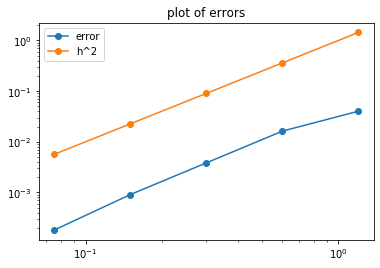

In [13]:
#plotting stuff
plt.loglog(hs,errs,"-o",label='error')
plt.loglog(hs,[h**2 for h in hs],"-o",label='h^2')
plt.title('plot of errors')
plt.legend()
plt.show()